In [1]:
!pip install -U numpy
!pip install -U pandas
!pip install -U openpyxl
!pip install -U seaborn
!pip install -U matplotlib
!pip install -U scikit-learn
!pip install -U shap
!pip install -U xgboost

In [2]:
import numpy as np
import pandas as pd
import openpyxl as xl
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 
import shap

/Users/alexglushko/ProgramProj/ChemML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data processing  

In [3]:
excel_path = r"../../static/mock/antibio_data/16.04.2024_Arbanas.xlsx"
artifacts_path = r"../../static/mock/antibio_artifacts/"
version = "0.2"

In [4]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df = tables_dict["Table1"]['dataframe']


worksheet name: Sheet1
tables in worksheet: 1
table name: Table1


In [5]:
df.columns

Index(['Type', 'RE', 'Образец', 'DФЗ', 'D,%', 'Dc', 'температура насыщения',
       'обьем кристаллизатора. мл ', 'длительность роста. час',
       'скорость перемешивания', 'плотность раствора. ', 'масса допанта ',
       'масса исходной соли', 'масса воды. г', 'концентрация допанта,', 'СМ',
       'сектор роста', 'масса кристалла', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8'],
      dtype='object')

In [6]:
X = df.drop(["RE", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", 'Образец'], axis=1)
y = df[["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8"]]
X.shape, y.shape

((14, 16), (14, 8))

In [7]:
# X['сектор роста'] = X['сектор роста'].astype("category")
# X['Type'] = X['Type'].astype("category")
X.dtypes

Type                            int64
DФЗ                           float64
D,%                           float64
Dc                            float64
температура насыщения         float64
обьем кристаллизатора. мл       int64
длительность роста. час         int64
скорость перемешивания          int64
плотность раствора.           float64
масса допанта                 float64
масса исходной соли             int64
масса воды. г                   int64
концентрация допанта,         float64
СМ                            float64
сектор роста                    int64
масса кристалла               float64
dtype: object

# Learning Utility

In [8]:
def learn_xgboost(X, y):
    parameters = {
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 2.5,],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring='neg_mean_absolute_error',
        refit=True,
        n_jobs=-1)
    clf.fit(X, y)
    best_xgboost = clf.best_estimator_
    print(clf.best_score_)
    print(clf.best_params_)
    return best_xgboost

In [9]:
def explain(model, X=X, name="model", is_save=False, color_bar=False):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, max_display=20, plot_size=[10, 6], show=False, color_bar=color_bar)
    if is_save:
        plt.savefig(f'{artifacts_path}{name}_{version}_shap.png', bbox_inches='tight')
    plt.show()

# All vs RE

In [10]:
y_all = y.to_numpy().T.flatten()
X_all = pd.concat([X]*y.shape[1])

-8.130154647374813
{'colsample_bytree': 0.6, 'gamma': 2, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}


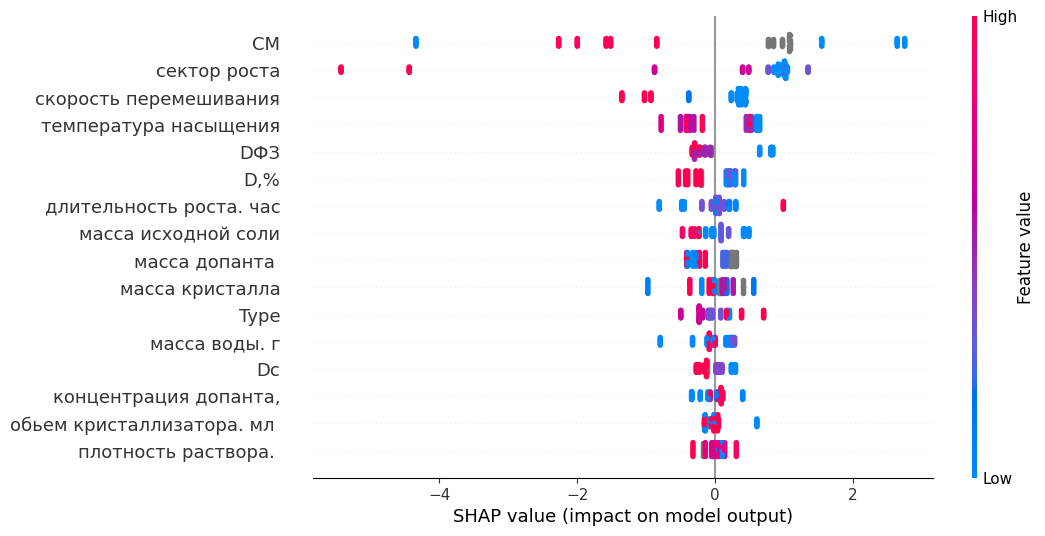

In [11]:
best_model = learn_xgboost(X_all, y_all)
explain(best_model, X=X_all, name="Mix", is_save=True, color_bar=True)

# Mushrooms and bacteria vs RE

In [22]:
8.6 / (y_mushrooms.mean() / 100)

16.78438661710037

In [12]:
y_bacteria = y[['D1', 'D2', 'D3', 'D4', 'D5']].to_numpy().T.flatten()
X_bacteria = pd.concat([X]*5)
y_mushrooms = y[['D6', 'D7', 'D8']].to_numpy().T.flatten()
X_mushrooms = pd.concat([X]*3)

-2.9931823185511996
{'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.6}


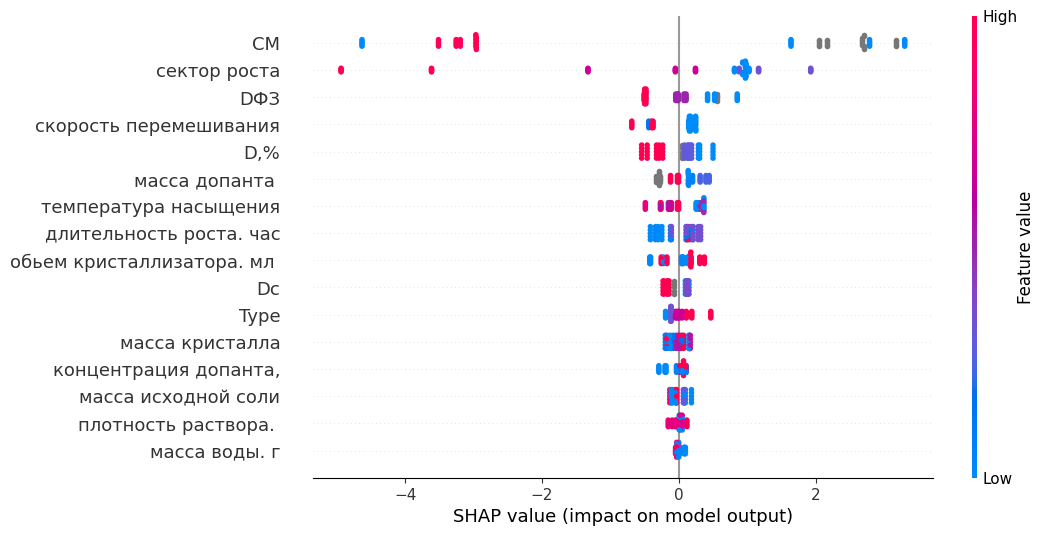

In [13]:
best_model = learn_xgboost(X_bacteria, y_bacteria)
explain(best_model, X=X_bacteria, name="Bacteria", is_save=True, color_bar=True)

-8.672193320592246
{'colsample_bytree': 1.0, 'gamma': 2.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


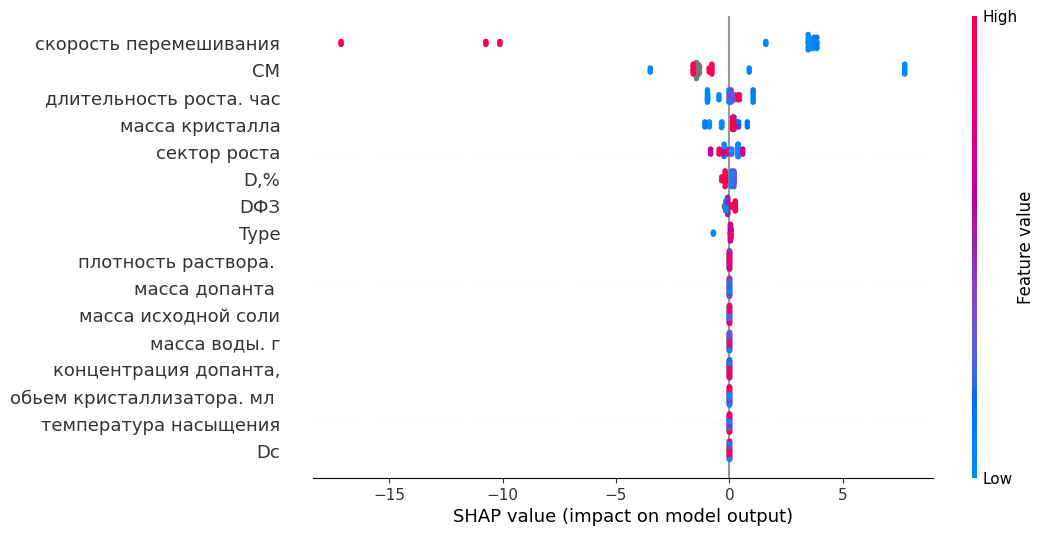

In [16]:
best_model = learn_xgboost(X_mushrooms, y_mushrooms)
explain(best_model, X=X_mushrooms, name="Mushrooms", is_save=True, color_bar=True)

# Individuals vs RE

D1


-1.6475921630859376
{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}


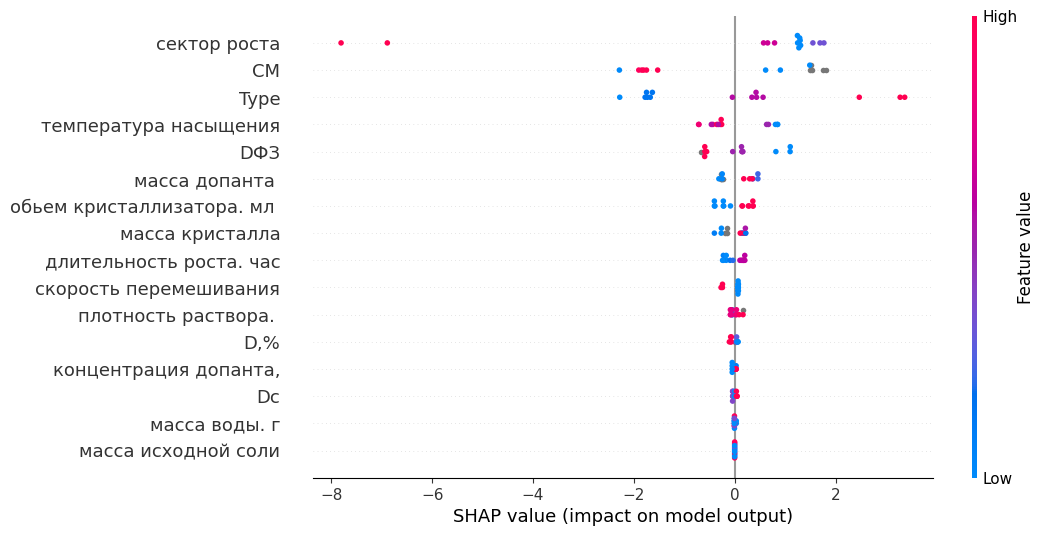

D2
-2.3597272237141924
{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}


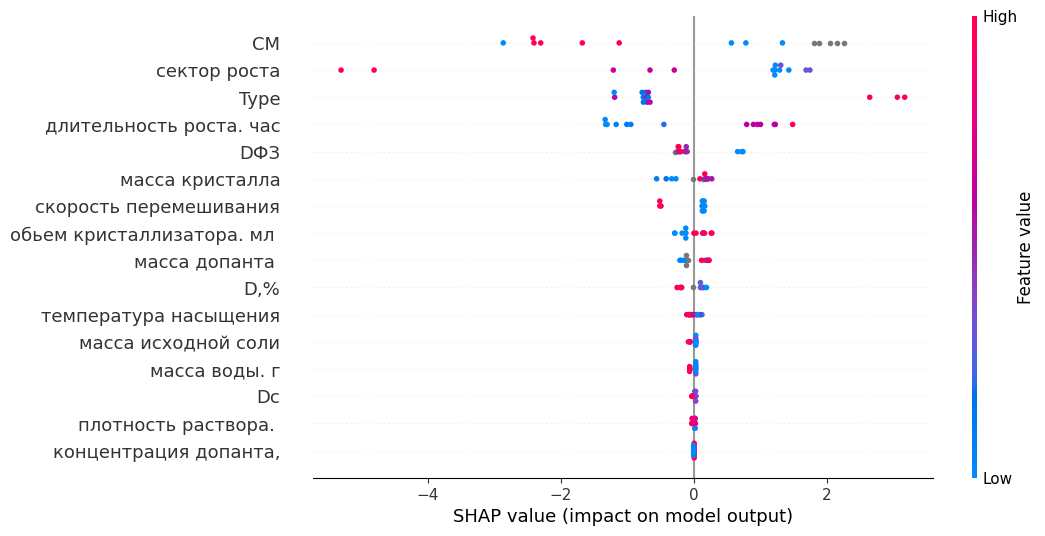

D3
-5.474114354451498
{'colsample_bytree': 0.8, 'gamma': 2.5, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}


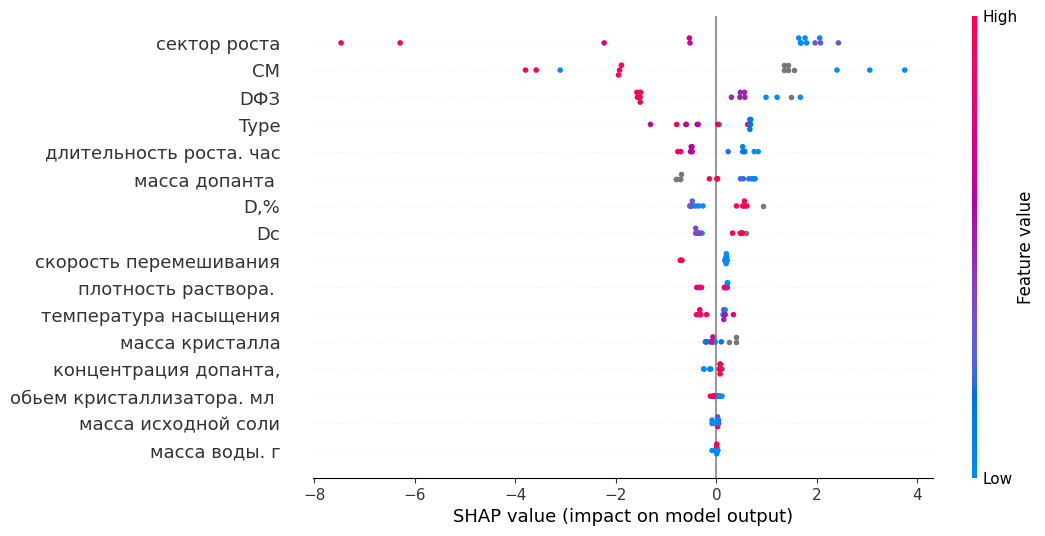

D4
-3.493939463297526
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 1.0}


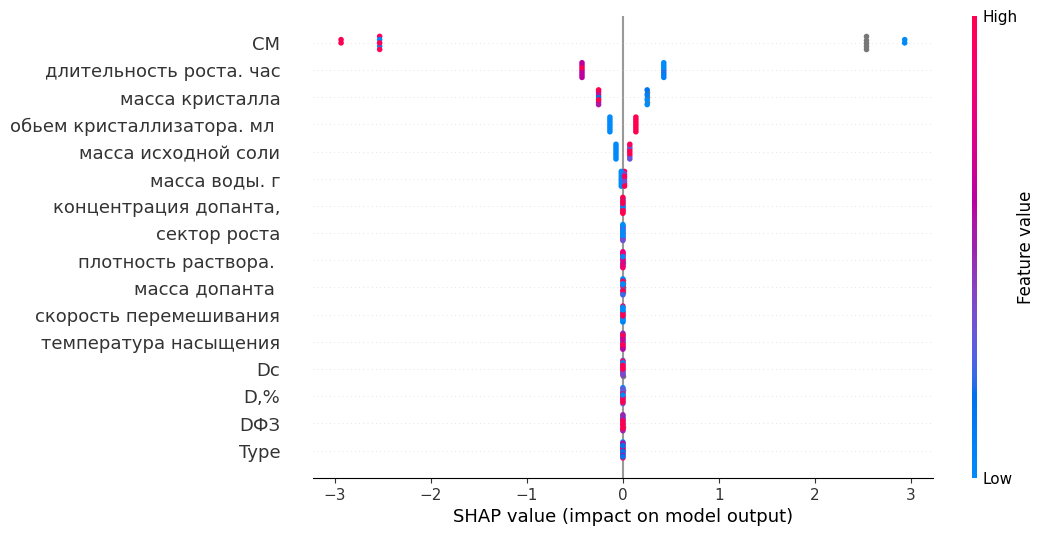

D5
-3.8746602376302084
{'colsample_bytree': 0.6, 'gamma': 2.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}


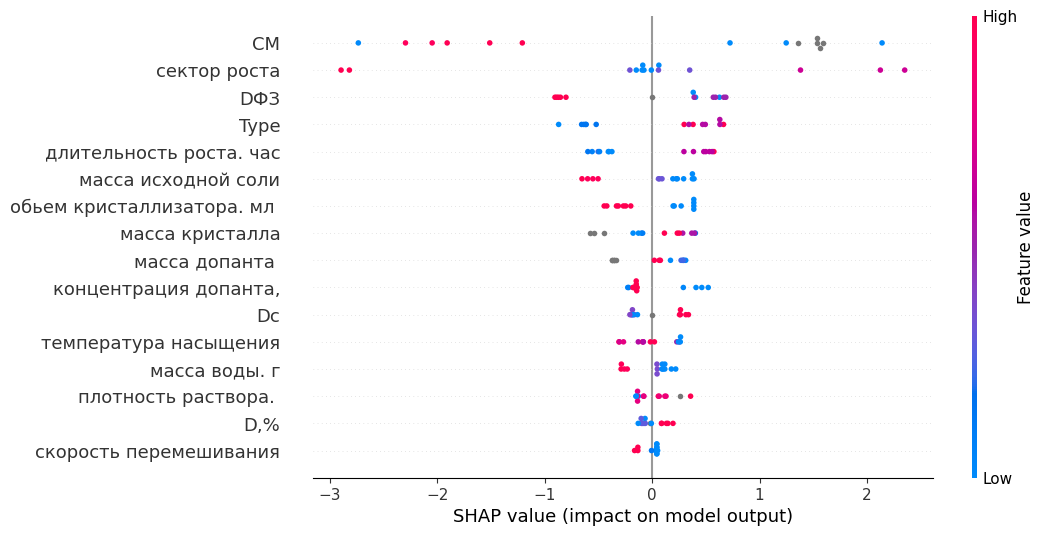

D6
-3.2139930725097656
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6}


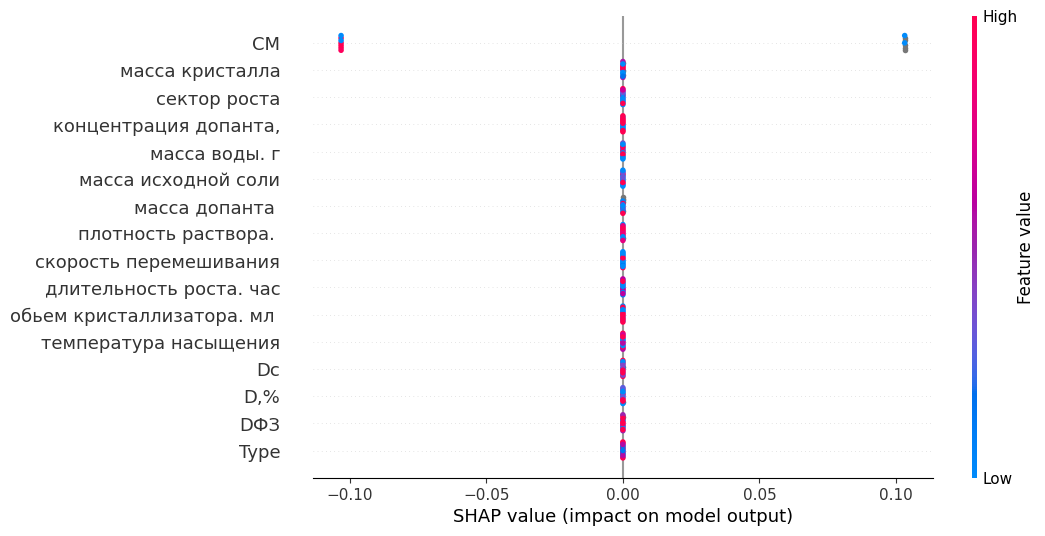

D7
-5.032611083984375
{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}


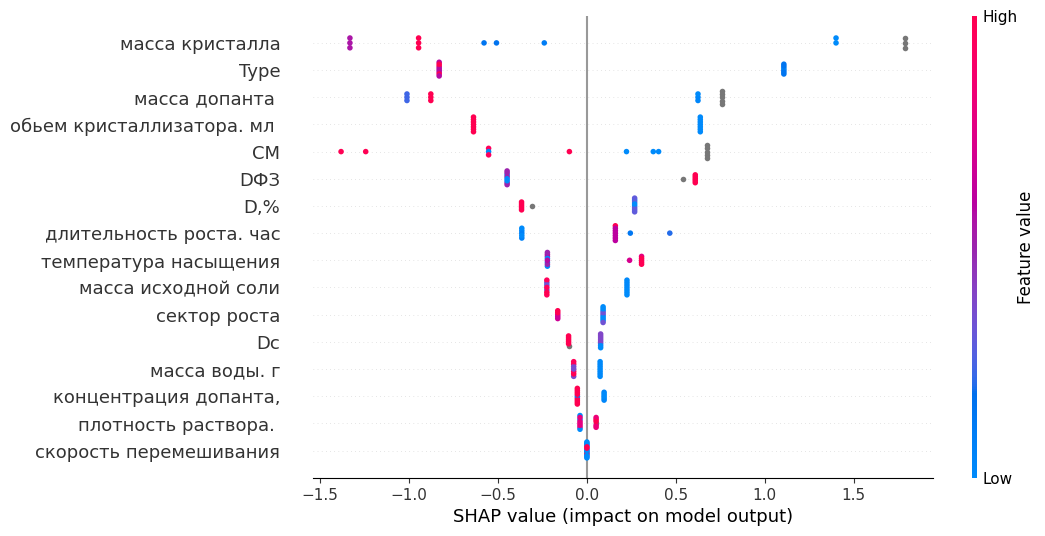

D8
-7.6560628255208325
{'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}


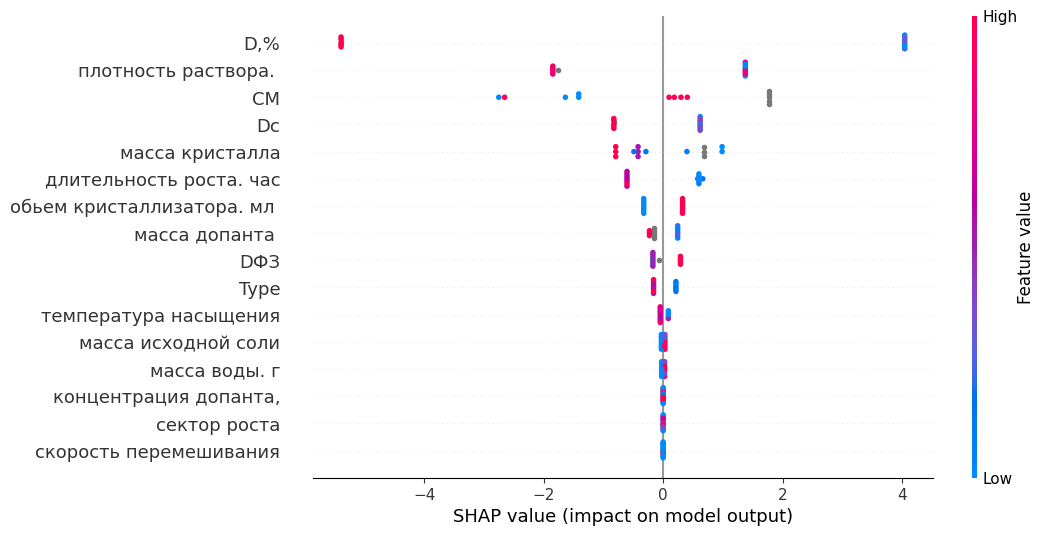

In [23]:
for col in y:
    print(col)
    best_model = learn_xgboost(X, y[col])
    explain(best_model, name=col, is_save=True, color_bar=True)